## **Import Required Library**


In [ ]:
# Install tensorflowjs
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
# Import library
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import zipfile
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import ResNet50
import tensorflowjs as tfjs
# import splitfolders
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Download Dataset**

In [ ]:
# Digunakan untuk kaggle API untuk dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download sudipp/garbage-dataset-9-classes

Dataset URL: https://www.kaggle.com/datasets/sudipp/garbage-dataset-9-classes
License(s): unknown
 99% 484M/489M [00:01<00:00, 386MB/s]
100% 489M/489M [00:01<00:00, 414MB/s]


In [ ]:
!unzip garbage-dataset-9-classes.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: garbage_classification/plastic/plastic652.jpg  
  inflating: garbage_classification/plastic/plastic653.jpg  
  inflating: garbage_classification/plastic/plastic654.jpg  
  inflating: garbage_classification/plastic/plastic655.jpg  
  inflating: garbage_classification/plastic/plastic656.jpg  
  inflating: garbage_classification/plastic/plastic657.jpg  
  inflating: garbage_classification/plastic/plastic658.jpg  
  inflating: garbage_classification/plastic/plastic659.jpg  
  inflating: garbage_classification/plastic/plastic66.jpg  
  inflating: garbage_classification/plastic/plastic660.jpg  
  inflating: garbage_classification/plastic/plastic661.jpg  
  inflating: garbage_classification/plastic/plastic662.jpg  
  inflating: garbage_classification/plastic/plastic663.jpg  
  inflating: garbage_classification/plastic/plastic664.jpg  
  inflating: garbage_classification/plastic/plastic665.jpg  
  inflating: garbage_classi

## **Data Loading**

,0
labels,
battery,1889
biological,1982
cardboard,2328
clothes,2106
glass,2011
metal,1789
paper,2310
plastic,1993
shoes,1977


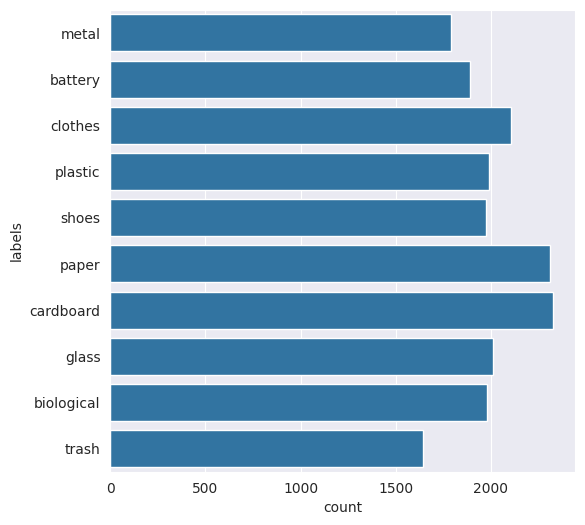

In [ ]:
# Path dataset
garbage_path = "/content/garbage_classification"

# list untuk menyimpan nama data, label, dan path asalnya
file_name = []
labels = []
full_path = []

# Menyatukan data tersebut menjadi satu dataframe
for path, subdirs, files in os.walk(garbage_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot untuk distribusi
Label = df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

## **Data Spliting**

In [ ]:
# Variable untuk x = path dan y = labels yang digunakan untuk data splitting
X = df['path']
y = df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_temp, y_train, y_temp= train_test_split(X, y,
                                                   test_size=0.3,
                                                   random_state=42)

# Split dataset menjadi data test dan data val
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                                test_size=0.50,
                                                random_state=42)

In [ ]:
# Nyatuin kedalam satu dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})

In [ ]:
# Menampilkan banyak data dalam per dataframe
print('train size', len(df_tr))
print('test size', len(df_te))
print('val size', len(df_val))

train size 14020
test size 3005
val size 3004


In [ ]:
# Menggabungkan semua dataframe tadi menjadi satu
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels    
test   battery        270
       biological     327
       cardboard      375
       clothes        307
       glass          290
       metal          255
       paper          329
       plastic        303
       shoes          303
       trash          246
train  battery       1312
       biological    1376
       cardboard     1619
       clothes       1490
       glass         1395
       metal         1273
       paper         1645
       plastic       1370
       shoes         1364
       trash         1176
val    battery        307
       biological     279
       cardboard      334
       clothes        309
       glass          326
       metal          261
       paper          336
       plastic        320
       shoes          310
       trash          222
dtype: int64 


                                                    path      labels    set
17551  /content/garbage_classification/biological/bio...  biological    val
1453   /content/garbage_classific

In [ ]:
# Memanggil dataset asli
datasource_path = "/content/garbage_classification"
# Membuat dataset yang akan digunakan nanti
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## **Normalization**

In [ ]:
# Normalisasi gambar
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    "Dataset-Final/train",
    target_size=(256, 256),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    "Dataset-Final/val",
    target_size=(256, 256),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    "Dataset-Final/test",
    target_size=(256, 256),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False
)

Found 14020 images belonging to 10 classes.
Found 3004 images belonging to 10 classes.
Found 3005 images belonging to 10 classes.


## **Exploratory Data Analysis (EDA)**

In [ ]:
# List label
label_kelas = list(train_generator.class_indices.keys())
label_kelas

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

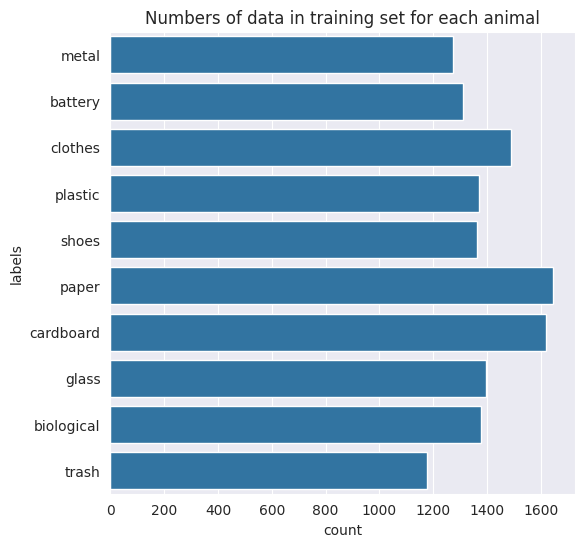

In [ ]:
# Source untuk dataset train yang digunakan
garbage_train = "Dataset-Final/train/"

# List untuk menyimpan data
file_name = []
labels = []
full_path = []

# Memasukan data tadi ke dataframe
for path, subdirs, files in os.walk(garbage_train):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Distribusi gambar
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
plt.title("Numbers of data in training set for each animal")
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

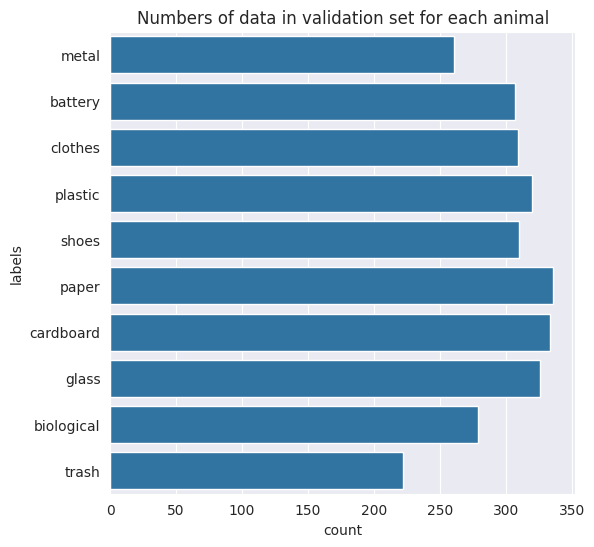

In [ ]:
# Source untuk dataset validation yang digunakan
garbage_val = "Dataset-Final/val/"

# List untuk menyimpan data
file_name = []
labels = []
full_path = []

# Memasukan data tadi ke dataframe
for path, subdirs, files in os.walk(garbage_val):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Distribusi gambar
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
plt.title("Numbers of data in validation set for each animal")
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

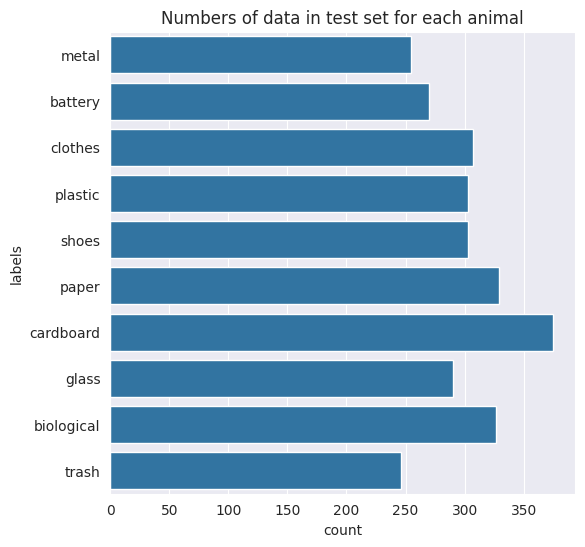

In [ ]:
# Source untuk dataset test yang digunakan
garbage_test = "Dataset-Final/test/"

# List untuk menyimpan data
file_name = []
labels = []
full_path = []

# Memasukan data tadi ke dataframe
for path, subdirs, files in os.walk(garbage_test):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Distribusi gambar
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
plt.title("Numbers of data in test set for each animal")
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## **Modeling**

In [ ]:
# Menggunakan pre-trained model MobileNetV2 untuk transfer learning
mobilenet_base = MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

mobilenet_base.trainable = False

<ipython-input-18-0b9282798f2a>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Training model
# Menghapus model sebelumnya jika perlu
# tf.keras.backend.clear_session()

# Model CNN
model_cnn = Sequential([
    mobilenet_base,

    # Layer pertama CNN
    Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(256,256,3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer kedua CNN
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer ketiga CNN
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Layer keempat CNN
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    # MaxPooling2D(2, 2),

    # Layer keempat CNN
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    # MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Change the number of units in the final Dense layer to match the number of classes (10)
    Dense(10, activation='softmax'),
])

# Compile model yang sudah dibuat
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print summary
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 8, 8, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 2, 2, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2, 2, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 1, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,877,898 (14.79 MB)

 Trainable params: 1,619,274 (6.18 MB)

 Non-trainable params: 2,258,624 (8.62 MB)

In [ ]:
# Callback early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Callback untuk mengurangi learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Menggabungkan callbacks
callbacks_list = [early_stop, reduce_lr]

In [ ]:
# Training model
history = model_cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs= 10,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.6499 - loss: 1.1008 - val_accuracy: 0.8725 - val_loss: 0.4249 - learning_rate: 0.0010
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.8946 - loss: 0.3633 - val_accuracy: 0.9101 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 44s 101ms/step - accuracy: 0.9368 - loss: 0.2176 - val_accuracy: 0.9118 - val_loss: 0.2781 - learning_rate: 0.0010
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 84s 105ms/step - accuracy: 0.9568 - loss: 0.1470 - val_accuracy: 0.9387 - val_loss: 0.2190 - learning_rate: 0.0010
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 46s 104ms/step - accuracy: 0.9651 - loss: 0.1194 - val_accuracy: 0.9358 - val_loss: 0.2562 - learning_rate: 0.0010
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 45s 102ms/step - accuracy: 0.9714 - loss: 0.0978 - val_accuracy: 0.9397 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.98

In [ ]:
# Menampilkan hasil accuracy test
test_loss, test_acc = model_cnn.evaluate(test_generator)
print(f"Test Accuracy:{test_acc:.2f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9612 - loss: 0.1692
Test Accuracy:0.95


In [ ]:
# Untuk history fase pertama
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Range epoch yang digunakan
epochs = range(1, len(acc) + 1)

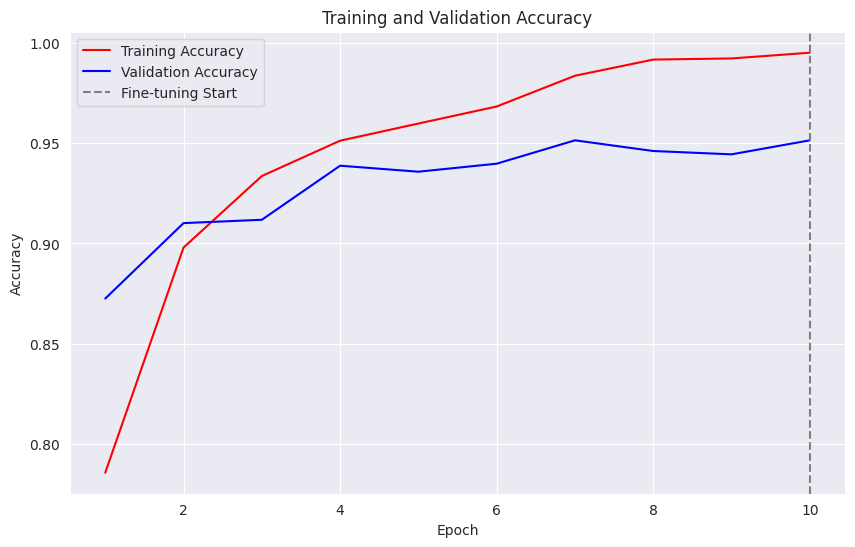

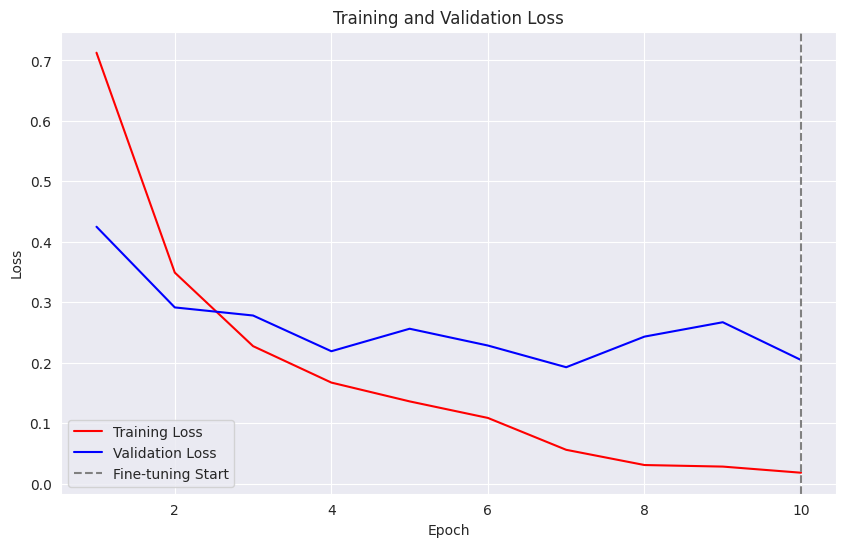

In [ ]:
# Untuk accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.axvline(x=len(history.history['accuracy']), color='gray', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Untuk loss Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.axvline(x=len(history.history['loss']), color='gray', linestyle='--', label='Fine-tuning Start')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

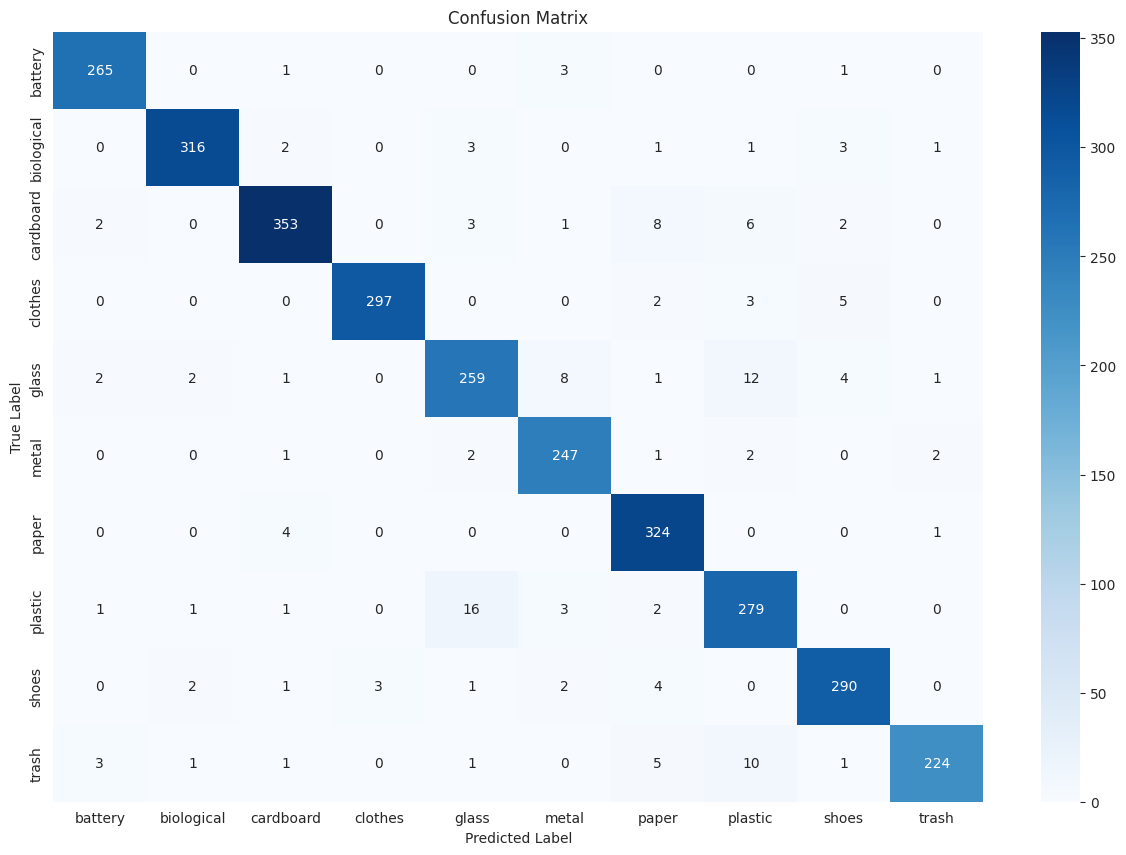

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       270
           1       0.98      0.97      0.97       327
           2       0.97      0.94      0.95       375
           3       0.99      0.97      0.98       307
           4       0.91      0.89      0.90       290
           5       0.94      0.97      0.95       255
           6       0.93      0.98      0.96       329
           7       0.89      0.92      0.91       303
           8       0.95      0.96      0.95       303
           9       0.98      0.91      0.94       246

    accuracy                           0.95      3005
   macro avg       0.95      0.95      0.95      3005
weighted avg       0.95      0.95      0.95      3005



In [ ]:
# Mereset test generator
test_generator.reset()

# Model yang sudah ditrain digunakan untuk matrik konfusion
predictions = model_cnn.predict(test_generator, verbose=0)
y_pred_classes = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Menampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_df = pd.DataFrame(data=cm)

plt.figure(figsize=(15, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_kelas,
            yticklabels=label_kelas)

# Menampilkan confusion matrix
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(y_true, y_pred_classes))

## **Saving Model**

In [ ]:
# Menyimpan model menggunakan savedModel
save_path = 'saved_model/'
tf.saved_model.save(model_cnn, save_path)

In [ ]:
# Membuat folder untuk model tersimpan dengan format tflite
os.makedirs('tflite', exist_ok=True)

# convert savedModel ke bentuk tflite
converter_tflite = tf.lite.TFLiteConverter.from_saved_model('saved_model/')
save_tflite = converter_tflite.convert()

# Menyimpan hasil convert ke dalam folder
with open('tflite/model.tflite', 'wb') as f:
    f.write(save_tflite)

# Menyimpan label yang digunakan
labels = label_kelas
with open('tflite/label.txt', 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

In [ ]:
# Membuat folder untuk menyimpan model dengan format tfjs
os.makedirs('tfjs_model', exist_ok=True)

# convert model kebentuk tfjs
!tensorflowjs_converter --input_format=tf_saved_model saved_model/ tfjs_model/

2025-06-07 07:07:54.947770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749280074.966917    4084 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749280074.972687    4084 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-07 07:07:59.136631: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1749280079.136807    4084 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
# Define the directory name
save_dir = 'h5_models'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Define the full path for the h5 file
save_path_h5 = os.path.join(save_dir, 'garbage_classification_model.h5')

# Save the model in HDF5 format inside the folder
model_cnn.save(save_path_h5)

In [ ]:
# Menyimpan model ke bentuk zip
def zip_files(zip_filename, paths_to_zip):
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for path in paths_to_zip:
            if os.path.isfile(path):
                zipf.write(path)
            else:
                for root, dirs, files in os.walk(path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        zipf.write(file_path)

zip_files('models.zip', ['saved_model', 'tfjs_model', 'tflite','h5_models'])

## **Inference**

Image: battery844.jpg, Actual: battery
Predicted Class: battery, Confidence: 99.96%
--------------------------------------------------
Image: biological_471.jpg, Actual: biological
Predicted Class: biological, Confidence: 99.99%
--------------------------------------------------
Image: cardboard_2116.jpg, Actual: cardboard
Predicted Class: cardboard, Confidence: 99.70%
--------------------------------------------------
Image: clothes850.jpg, Actual: clothes
Predicted Class: clothes, Confidence: 100.00%
--------------------------------------------------
Image: green-glass200.jpg, Actual: glass
Predicted Class: glass, Confidence: 99.45%
--------------------------------------------------
Image: metal491.jpg, Actual: metal
Predicted Class: metal, Confidence: 99.92%
--------------------------------------------------
Image: paper901.jpg, Actual: paper
Predicted Class: paper, Confidence: 99.98%
--------------------------------------------------
Image: plastic633.jpg, Actual: plastic
Predicted

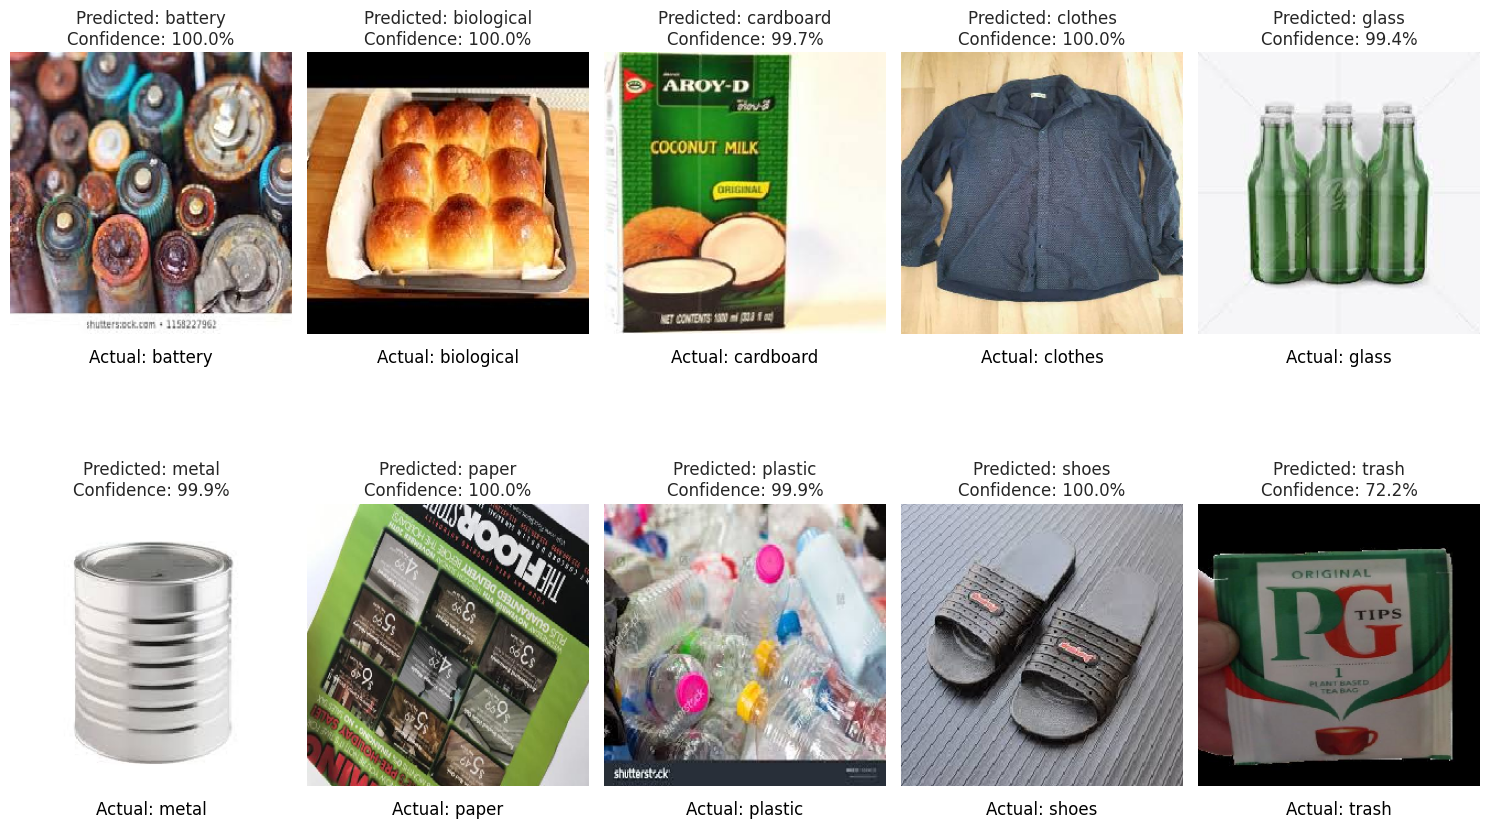

In [ ]:
# Load model dari savedmodel
loaded_model = tf.saved_model.load("saved_model/")
infer = loaded_model.signatures["serving_default"]

# Directory untuk inference
inference_dir = "/content/Dataset-Final/test"

# Labels
# class_labels = ["battery", "biological", "cardboard", "clothes", "glass","metal","paper","plastic","shoes","trash"]
class_labels = label_kelas

# Membuat plot
plt.figure(figsize=(15, 10))

# Melakukan inference untuk tiap class
for i, class_name in enumerate(class_labels):
    class_dir = os.path.join(inference_dir, class_name)

    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    all_images = os.listdir(class_dir)
    if not all_images:
        print(f"No images found in {class_dir}")
        continue

    img_name = random.choice(all_images)
    img_path = os.path.join(class_dir, img_name)

    # Load gambar yang sudah dipreprocess
    img = image.load_img(img_path, target_size=(256, 256))
    img_display = np.array(img)

    image_array = image.img_to_array(img) / 255.0
    image_expand = np.expand_dims(image_array, axis=0)

    # Prediksi menggunakan savemodel
    predictions_dict = infer(tf.constant(image_expand, dtype=tf.float32))
    output_key = list(predictions_dict.keys())[0]
    predictions = predictions_dict[output_key].numpy()

    # Hasil Prediksi
    predicted_class_index = np.argmax(predictions[0])
    predicted_class = class_labels[predicted_class_index]
    confidence = float(predictions[0][predicted_class_index]) * 100

    # Menampilkan hasil prediksi dalam bentuk non-plot
    print(f"Image: {img_name}, Actual: {class_name}")
    print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")
    print("-" * 50)

    # Menampilkan gambar yang digunakan untuk prediksi
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(img_display)
    ax.set_title(f"Predicted: {predicted_class}\nConfidence: {confidence:.1f}%")
    ax.axis("off")
    ax.text(0.5, -0.1, f"Actual: {class_name}", size=12, ha="center",
            transform=ax.transAxes, color='black')

plt.tight_layout()
plt.show()

Saving WhatsApp Image 2025-06-07 at 14.16.36.jpeg to WhatsApp Image 2025-06-07 at 14.16.36.jpeg


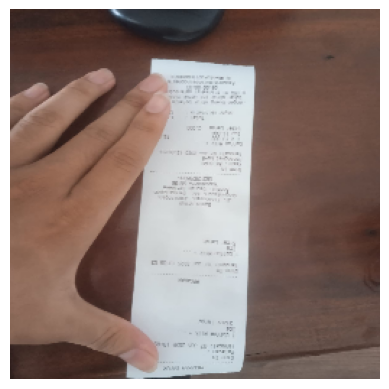

Predicted Class: paper, Confidence: 99.87%


In [ ]:
from google.colab import files

# Untuk upload gambar
uploaded = files.upload()

for fn in uploaded.keys():
  # Load gambar
  img_path = fn
  img = image.load_img(img_path, target_size=(256, 256))

  # Display hasil upload
  img_display = np.array(img)
  plt.imshow(img_display)
  plt.axis("off")
  plt.show()

  # Preprocess untuk image
  image_array = image.img_to_array(img) / 255.0
  image_expand = np.expand_dims(image_array, axis=0)

  # Load model
  # loaded_model = tf.saved_model.load("saved_model/")
  infer = loaded_model.signatures["serving_default"]

  # Melakukan Inference
  predictions_dict = infer(tf.constant(image_expand, dtype=tf.float32))
  output_key = list(predictions_dict.keys())[0]
  predictions = predictions_dict[output_key].numpy()

  # Mengeluarkan hasil dan nilai confidence
  predicted_class_index = np.argmax(predictions[0])
  predicted_class = label_kelas[predicted_class_index]
  confidence = float(predictions[0][predicted_class_index]) * 100

  # Print hasil prediksi
  print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%")